In [2]:
# =============================================================================
# IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# =============================================================================
# 1. CHARGEMENT (Robust Loading)
# =============================================================================
file_path = r"C:\Users\hp\Desktop\databases\us-accidents-analysis-2026\paquets\data_time.parquet"

try:
    df = pd.read_parquet(file_path, engine='pyarrow')
    print(f"✅ Chargé {df.shape[0]:,} lignes depuis {file_path}")
except Exception:
    print("⚠️ 'data_time.parquet' introuvable. Tentative avec 'data_physics.parquet'...")
    try:
        df = pd.read_parquet('paquets/data_physics.parquet', engine='pyarrow')
        print("✅ Chargé via data_physics!")
    except Exception as e:
        print(f"❌ CRITICAL ERROR: Aucun fichier trouvé. {e}")
        raise

✅ Chargé 6,979,315 lignes depuis C:\Users\hp\Desktop\databases\us-accidents-analysis-2026\paquets\data_time.parquet


In [4]:
# =============================================================================
# 2. FEATURE ENGINEERING
# =============================================================================
# Convertir Start_Time
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Extraire les composants
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.dayofweek
df['Month'] = df['Start_Time'].dt.month
df['Year'] = df['Start_Time'].dt.year

# Noms des jours (pour les graphiques)
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Weekday_Name'] = df['Weekday'].map(lambda x: weekday_names[x])

# Saisons
def get_season(month):
    if month in [12, 1, 2]: return '❄️ Winter'
    elif month in [3, 4, 5]: return '🌸 Spring'
    elif month in [6, 7, 8]: return '☀️ Summer'
    else: return '🍂 Fall'

df['Season'] = df['Month'].apply(get_season)
df['Is_Weekend'] = df['Weekday'].isin([5, 6])

In [5]:
# =============================================================================
# 3. STATISTIQUES & ANALYSE
# =============================================================================

# --- A. RUSH HOUR (Heure de pointe) ---
df['Hour_Group'] = pd.cut(df['Hour'], 
                          bins=[-1, 6, 9, 12, 15, 17, 19, 22, 24], 
                          labels=['🌙 Night', '🌅 Morning Rush', '🌤️ Midday', 
                                  '🌇 Afternoon', '🌆 Late P.M.', '🚨 Evening Rush', 
                                  '🌃 Evening', '🌙 Late Night'])

print("\n🕒 STATS PAR HEURE:")
# ⚠️ FIX: Used 'Distance' instead of 'Distance(mi)'
hour_stats = df.groupby('Hour_Group')[['Severity', 'Distance']].mean()
print(hour_stats)

# --- B. WEEKEND VS SEMAINE ---
print("\n📅 WEEKEND VS SEMAINE:")
week_stats = df.groupby('Is_Weekend')[['Severity', 'Distance']].mean()
week_stats.index = ['Weekday', 'Weekend']
print(week_stats)


🕒 STATS PAR HEURE:
                Severity  Distance
Hour_Group                        
🌙 Night         2.228596  0.589359
🌅 Morning Rush  2.209703  0.401502
🌤️ Midday       2.233628  0.526651
🌇 Afternoon     2.224099  0.620232
🌆 Late P.M.     2.227751  0.472882
🚨 Evening Rush  2.250242  0.439728
🌃 Evening       2.264484  0.566360
🌙 Late Night    2.221615  0.642641

📅 WEEKEND VS SEMAINE:


C:\Users\hp\AppData\Local\Temp\ipykernel_1120\3090546966.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hour_stats = df.groupby('Hour_Group')[['Severity', 'Distance']].mean()


         Severity  Distance
Weekday  2.220317  0.496998
Weekend  2.277891  0.618827


c:\Users\hp\AppData\Local\Programs\Python\Python314\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 10052 (\N{SNOWFLAKE}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\hp\AppData\Local\Programs\Python\Python314\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\hp\AppData\Local\Programs\Python\Python314\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\hp\AppData\Local\Programs\Python\Python314\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9728 (\N{BLACK SUN WITH RAYS}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\hp\AppData\Local\Programs\Python\Python314\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 127810 (\N{FALLEN LEAF}) missing from font(s) Arial.
  fig.canvas.draw()
C:\Users\hp\AppData\Local\Temp\ipykernel_1120\3362066404.py:33: UserWa

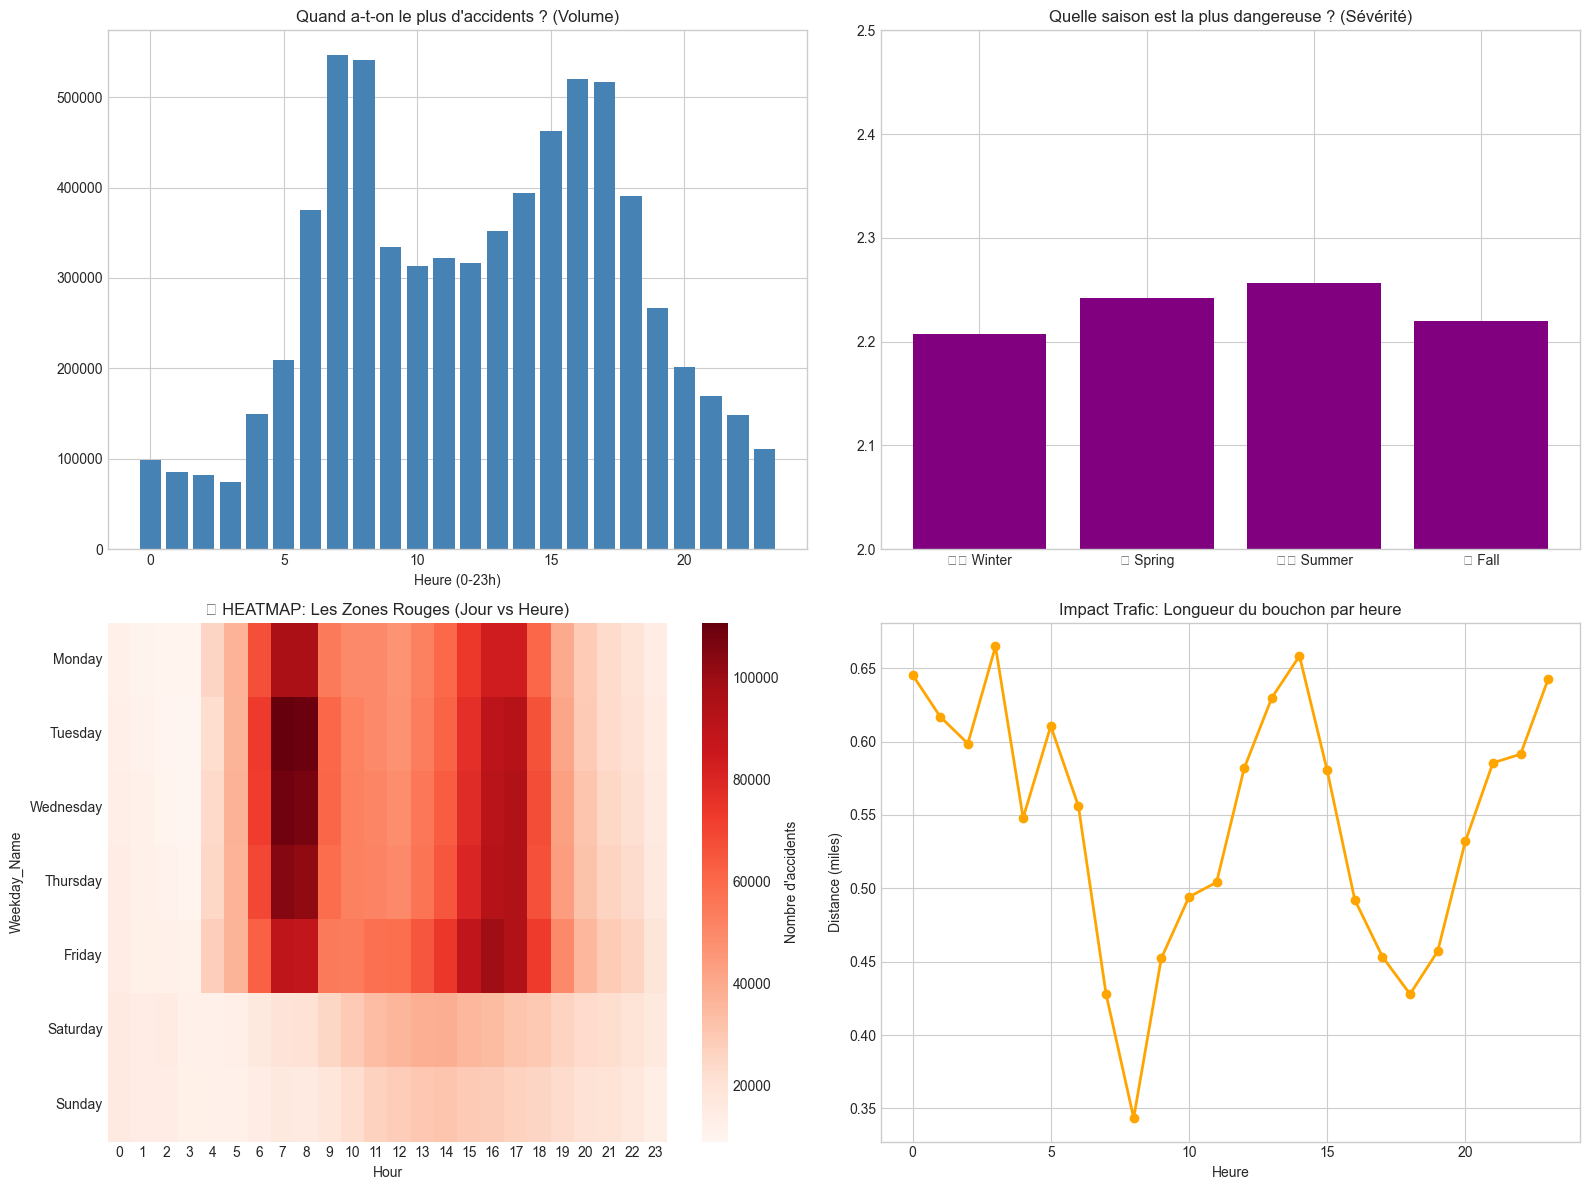


✅ Analyse terminée. Copiez les graphiques pour le rapport.


In [6]:
# =============================================================================
# 4. VISUALISATIONS (The Money Shots)
# =============================================================================
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Graph 1: Volume par Heure
hourly_counts = df['Hour'].value_counts().sort_index()
axes[0, 0].bar(hourly_counts.index, hourly_counts.values, color='steelblue')
axes[0, 0].set_title('Quand a-t-on le plus d\'accidents ? (Volume)')
axes[0, 0].set_xlabel('Heure (0-23h)')

# Graph 2: Sévérité par Saison
season_order = ['❄️ Winter', '🌸 Spring', '☀️ Summer', '🍂 Fall']
season_sev = df.groupby('Season')['Severity'].mean().reindex(season_order)
axes[0, 1].bar(season_sev.index, season_sev.values, color='purple')
axes[0, 1].set_title('Quelle saison est la plus dangereuse ? (Sévérité)')
axes[0, 1].set_ylim(2.0, 2.5) # Zoom pour voir la différence

# Graph 3: HEATMAP (Jour vs Heure) - LE PLUS IMPORTANT
# Pivot: Lignes = Jours, Colonnes = Heures, Valeurs = Nombre d'accidents
heatmap_data = df.pivot_table(index='Weekday_Name', columns='Hour', values='Severity', aggfunc='count').reindex(weekday_names)
sns.heatmap(heatmap_data, cmap='Reds', ax=axes[1, 0], cbar_kws={'label': 'Nombre d\'accidents'})
axes[1, 0].set_title('🔥 HEATMAP: Les Zones Rouges (Jour vs Heure)')

# Graph 4: Distance par Heure (Impact Trafic)
dist_by_hour = df.groupby('Hour')['Distance'].mean()
axes[1, 1].plot(dist_by_hour.index, dist_by_hour.values, marker='o', color='orange', linewidth=2)
axes[1, 1].set_title('Impact Trafic: Longueur du bouchon par heure')
axes[1, 1].set_xlabel('Heure')
axes[1, 1].set_ylabel('Distance (miles)')

plt.tight_layout()
plt.show()

print("\n✅ Analyse terminée. Copiez les graphiques pour le rapport.")